In [1]:
from src.loader import Loader
from matplotlib import pyplot

loader = Loader((224, 224))

In [2]:
dataset = loader.create_dataset()
dataset.summary()

-------------------- Dataset Summary --------------------

Number of train images :  5216


Number of test images :  624


Number of validation images :  16


Shape of each images :  (224, 224, 3)
---------------------------------------------------------


In [3]:
#Balance dataset for better training
dataset.balance_data(0.8, 0.10)
dataset.summary()

-------------------- Dataset Summary --------------------

Number of train images :  4684


Number of test images :  586


Number of validation images :  586


Shape of each images :  (224, 224, 3)
---------------------------------------------------------


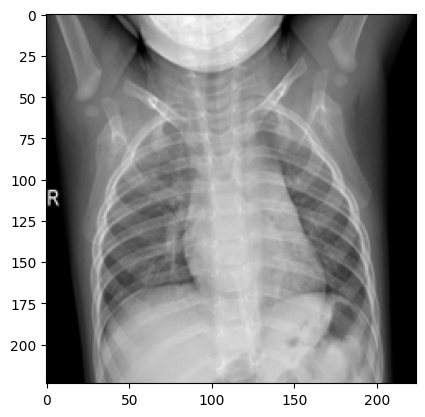

In [4]:
pyplot.imshow(dataset.test_images[0])

In [4]:
# Tensorboard init

%load_ext tensorboard
%tensorboard --logdir logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# VGG16

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Conv2D, Lambda, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
import tensorflow as tf

vgg_conv = VGG16(weights='./vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(vgg_conv.input, x)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.legacy.SGD(learning_rate=0.005, momentum=0.9), metrics=["accuracy"])

In [6]:
import datetime

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(dataset.train_images, dataset.train_labels,
          epochs=25,
          batch_size=128,
          shuffle=True,
          validation_data=(dataset.val_images, dataset.val_labels))
        #   callbacks=[tensorboard_callback])

Epoch 1/25
37/37 [==============================] - 1108s 30s/step - loss: 0.4298 - accuracy: 0.8061 - val_loss: 0.2954 - val_accuracy: 0.8686
Epoch 2/25
37/37 [==============================] - 1300s 35s/step - loss: 0.1888 - accuracy: 0.9283 - val_loss: 0.1867 - val_accuracy: 0.9266
Epoch 3/25
11/37 [=======>......................] - ETA: 14:56 - loss: 0.1987 - accuracy: 0.9219

KeyboardInterrupt: 

In [12]:
model.evaluate(dataset.test_images, dataset.test_labels, verbose=2)

19/19 - 92s - loss: 0.1013 - accuracy: 0.9608 - 92s/epoch - 5s/step


[0.10130023956298828, 0.9607508778572083]

In [11]:
model.save('model_balance')

# loaded_model2 = tf.keras.models.load_model('model')

INFO:tensorflow:Assets written to: model_balance/assets


INFO:tensorflow:Assets written to: model_balance/assets


# Model Test

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Charger le modèle VGG16 pré-entraîné sans la couche supérieure (top)
vgg_conv = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Construire le modèle personnalisé
x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(vgg_conv.input, x)

In [23]:
# Chemin vers votre fichier .h5
weights_path = './model_checkpoints/checkpoint-22-0.98.h5'

# Charger les poids
model.load_weights(weights_path)

from tensorflow.keras import optimizers

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.legacy.SGD(learning_rate=0.005, momentum=0.9),
              metrics=["accuracy"])

model.evaluate(dataset.test_images, dataset.test_labels, verbose=2)

19/19 - 161s - loss: 0.0209 - accuracy: 0.9915 - 161s/epoch - 8s/step


[0.020932016894221306, 0.9914675951004028]

In [14]:
import scipy.ndimage as sp
import matplotlib.pyplot as plt
import numpy as np

def plot_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = int(pred > 0.5)
    print('pred : ', pred_class)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, 0]
    intermediate = Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Pneumonia' if pred_class == 1 else 'No Pneumonia')

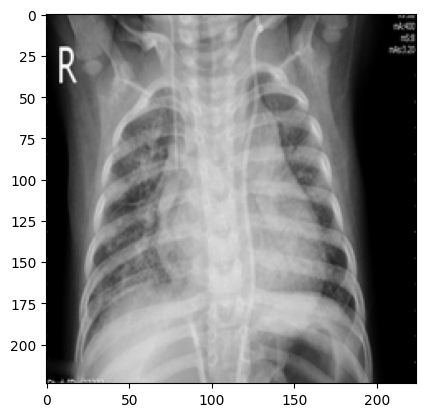

In [22]:
pyplot.imshow(dataset.test_images[3])

1/1 [==============================] - 0s 133ms/step
pred :  0
1/1 [==============================] - 0s 157ms/step


/var/folders/21/b_d74zx567v6lvf8gnmcn52m0000gn/T/ipykernel_6360/3957289125.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_class = int(pred > 0.5)


0


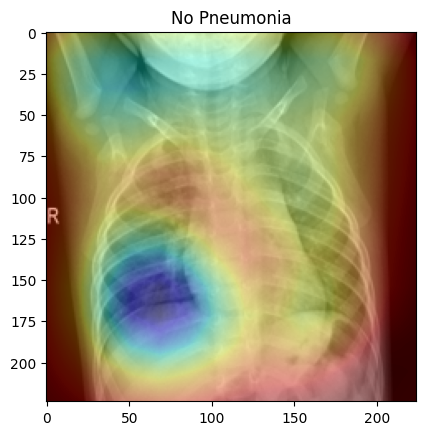

In [27]:
plot_activation(dataset.test_images[0])
print(dataset.test_labels[0])